In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [2]:
import os

os.chdir("..")
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from render_psam import render_psams
from orthogonal_dfa.spliceai.best_psams_for_lssi import (
    train_and_evaluate_lssi_psams,
    plot_accuracies,
    accuracy_vs_loss,
    train_psams_for_splice_site,
)
from orthogonal_dfa.manual_dfa.spilce_site_dfa import (
    splice_site_psam_pdfa,
)
from orthogonal_dfa.experiments.splice_sites_train import (
    trained_splice_site,
    plot_learning_curve,
)

In [4]:
don = train_and_evaluate_lssi_psams("donor", num_batches=100_000, lr=3e-4)
acc = train_and_evaluate_lssi_psams("acceptor", num_batches=100_000, lr=3e-4)

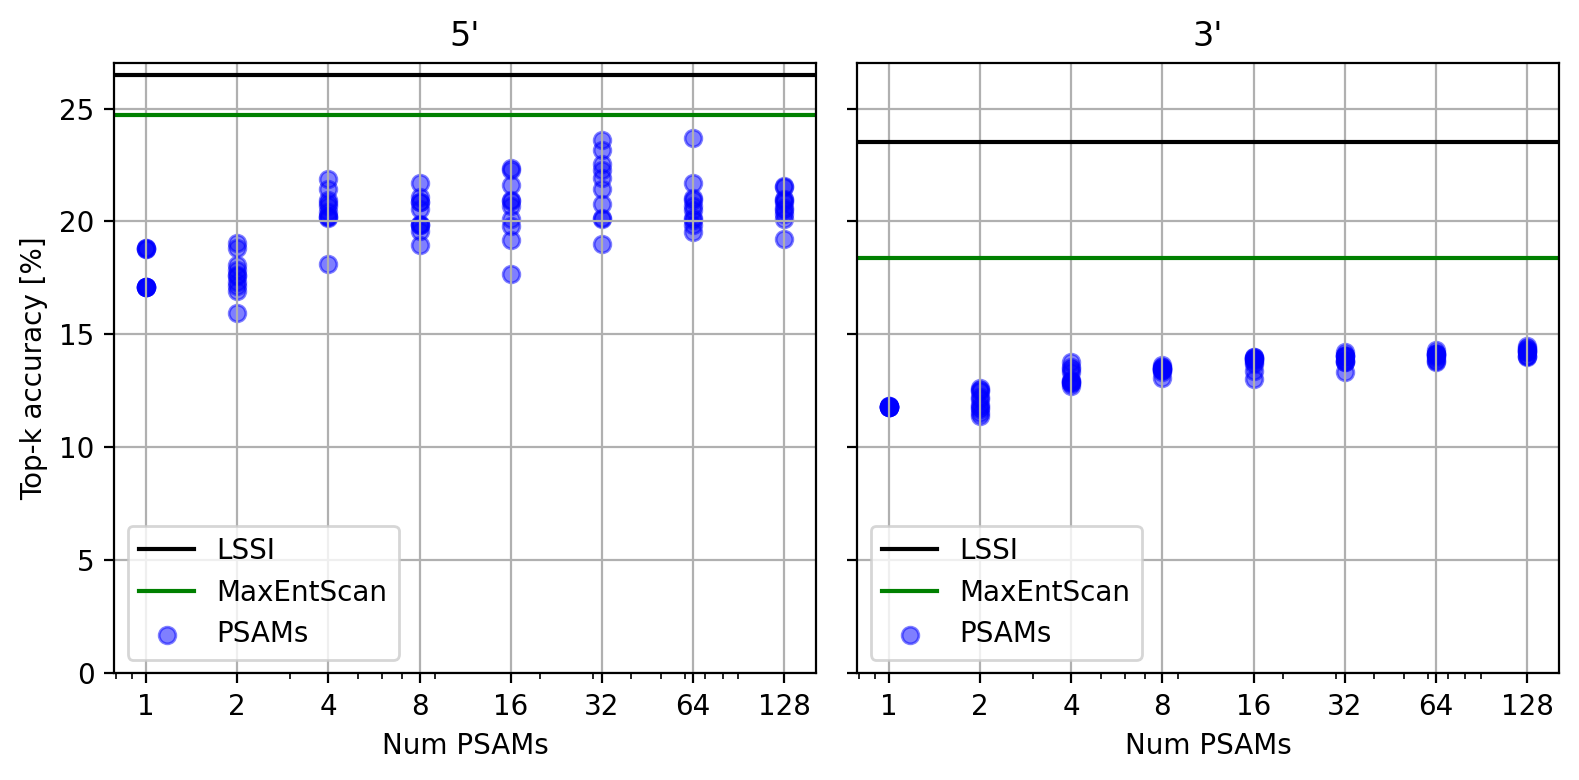

In [5]:
_, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=200, sharey=True, tight_layout=True)

plot_accuracies(don, 26.5, 24.7, "5'", ax=axs[0])
plot_accuracies(acc, 23.5, 18.4, "3'", ax=axs[1])
axs[0].set_ylabel("Top-k accuracy [%]")
for ax in axs:
    ax.grid()
plt.show()

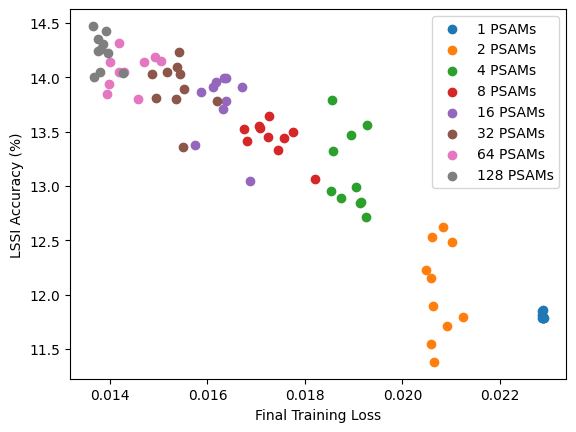

In [6]:
accuracy_vs_loss(acc)

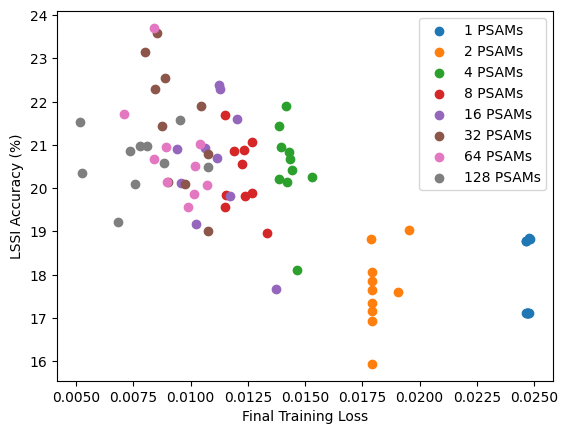

In [7]:
accuracy_vs_loss(don)

In [8]:
def draw_psams(psams_d, psams_a):
    axs = render_psams(
        [psams[i] for i in range(len(psams_d)) for psams in [psams_d, psams_a]],
        names=[
            f"{name} #{idx + 1}" for idx in range(len(psams_d)) for name in ["5'", "3'"]
        ],
        psam_mode="raw",
        ncols=2,
    )
    minima, maxima = np.array([ax.get_ylim() for ax in axs]).T
    for ax in axs:
        ax.set_ylim(minima.min(), maxima.max())
    plt.show()

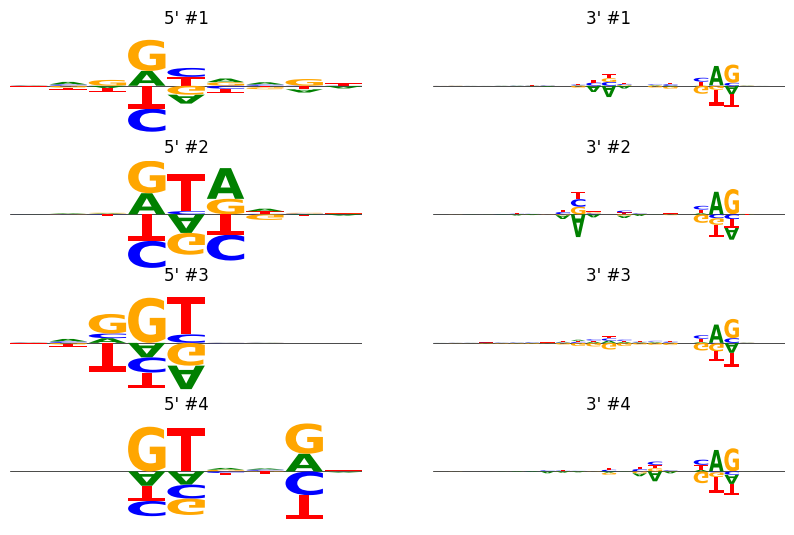

In [9]:
axs = draw_psams(
    psams_d=splice_site_psam_pdfa("donor", 0.5).psam.sequence_logos,
    psams_a=splice_site_psam_pdfa("acceptor", 0.5).psam.sequence_logos,
)

In [10]:
don_trained, don_curve = trained_splice_site("donor", 50_000)
acc_trained, acc_curve = trained_splice_site("acceptor", 30_000)

In [11]:
def pull_psams(model):
    transition_prob = (
        model.pdfa.logit_transition_probs.softmax(-1)[0, 1:, 1].detach().numpy()
    )
    assert ((transition_prob < 1e-5) | (transition_prob > 0.99)).all()
    mask = transition_prob > 0.5
    logos = model.psam.sequence_logos.copy()
    logos[~mask] = np.nan
    return logos

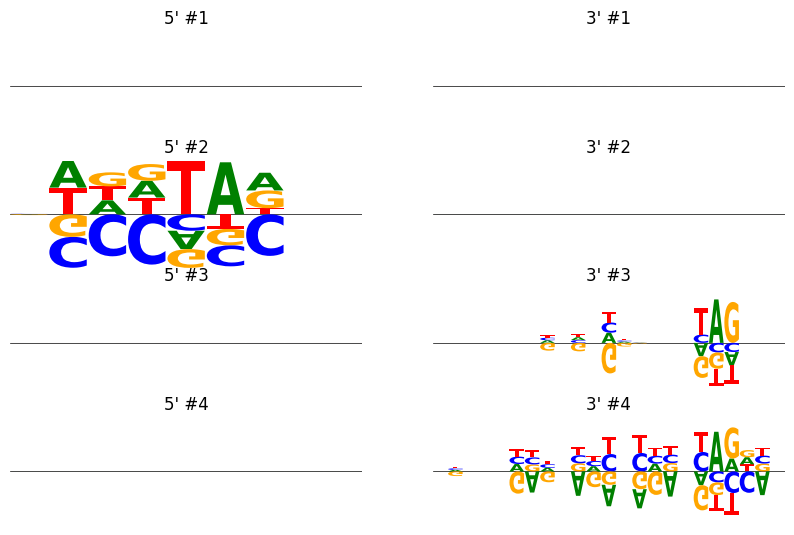

In [12]:
draw_psams(
    psams_d=pull_psams(don_trained),
    psams_a=pull_psams(acc_trained),
)

Text(0.5, 1.0, "3'")

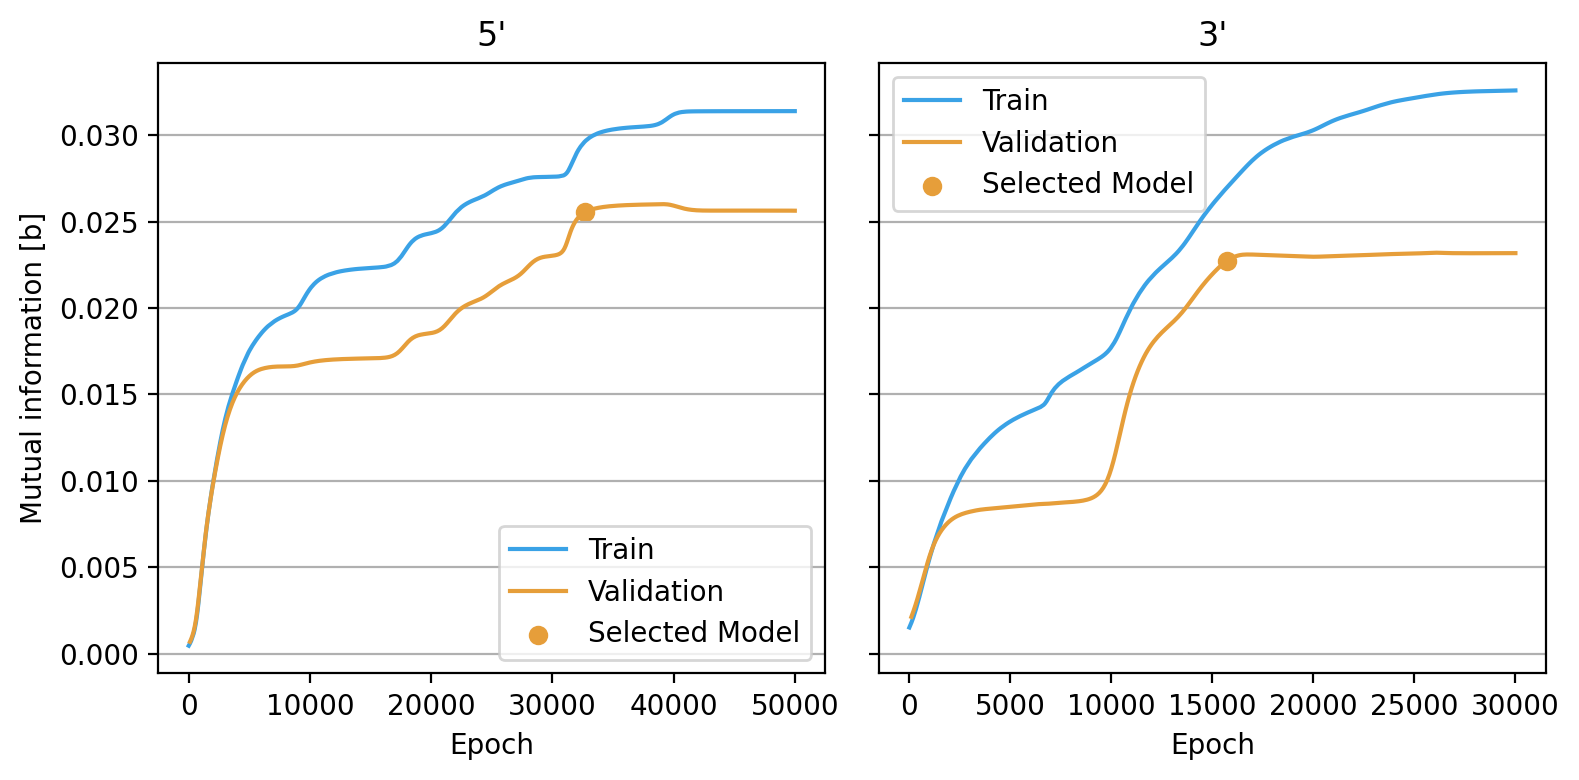

In [13]:
_, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=200, sharey=True, tight_layout=True)
plot_learning_curve(don_curve, ax=axs[0])
plot_learning_curve(acc_curve, ax=axs[1])
axs[1].set_ylabel("")
axs[0].set_title("5'")
axs[1].set_title("3'")